In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
#we will be building micrograd from scratch
class value:
    def __init__(self, data, children = (), op='', label =""):
        self.data = data
        self.children = set(children)
        self.grad = 0 # grad is 0 by default
        self.backward = lambda : None #empty lambda function by default
        self.op = op
        self.label = label
    
    def __add__(self,other):
        out = value(self.data + other.data, children=(self,other),op='+')
        def backward():
            #basically chain rule, lets say for example:
            # there is L -> Z -> X+Y 
            # now how tweaking x or y is going to affect L depends on
            # ∂L/∂z * ∂z/∂x = ∂L/∂x this is basically chain rule, and we know that 
            # ∂z/∂x = 1. by derivative
            # (f(x+h) - f(x)) / h 
            self.grad += out.grad * 1 
            other.grad += out.grad * 1
        out.backward = backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.backward = backward

        return out
    
    

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((v,child))
                build(child)
    build(root)
    return nodes,edges

In [4]:
from graphviz import Digraph

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    
    dot.node( name  = uid, label = "{%s | data %4f}" %(n.label, n.data))
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [6]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin\\'

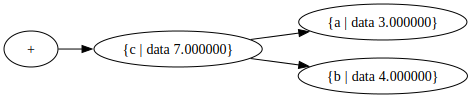

In [7]:
# Render the graph and display the SVG explicitly.
from IPython.display import SVG, display
dot = draw_dot(c)
display(SVG(dot.pipe(format='svg')))